# Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
#stack_df = pd.read_csv('../../99_Ensemble/99_v1_04/result/stack_99_v1_04_02.csv')
stack_df = pd.read_csv('../../29_Pseudo4/exp/result/29_v2_01/oof_df.csv')
stack_df = stack_df.rename(columns={'pred_ineffective':'Ineffective','pred_adequate':'Adequate','pred_effective':'Effective'})
num_models = 1 #7

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 11)


discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness  Ineffective  Adequate  Effective  label      loss  \
0                Adequate     0.021704  0.927354   0.050943      1  0.075420   
1                Adequate     0.077561  0.879470   0.042969      1  0.128435   
2                Adequate     0.203750  0.780750   0.015500      1  0.247500   
3                Adequate     0.274948  0.712694   0.012357      1  0.338702   
4                Adequate     0.295401  0.697455   0.007143      1  0.360317   

                                            prob_seq  
0  [[0.13634923 0.8468392  0.01681152]\n [0.07866...  
1  [[0.0755257  0.86845165 0.05602267]\n [0.06394...  
2  [[0.13821203 0.8419575  0.01983041]\n [0.15052...  
3  [[0.23645823 0.7562572  0.00728461]\n [0.38560...  
4  [[0.24329548 0.74282235 0.01388219]\n [0.18840...

In [2]:
# https://stackoverflow.com/questions/45704999/how-to-convert-vector-wrapped-as-string-to-numpy-array-in-pandas-dataframe
import numpy as np
train_df['prob_seq'] = train_df['prob_seq'].apply(lambda x:np.fromstring(
                                x.replace('\n','')
                                 .replace('[','')
                                 .replace(']','')
                                 .replace('  ',' '), sep=' '))
prob_seqs = [train_df['prob_seq'].values[i].reshape(-1,3) for i in range(len(train_df))]

/home/takesako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


# Features

In [3]:
from shujun_features import get_xgb_features

train_df = get_xgb_features(train_df, prob_sequences=prob_seqs, use_prob_seq=True)
print('train_df.shape = ', train_df.shape)
train_df.head(2)

36765it [00:01, 21659.34it/s]
 13%|█▎        | 4684/36765 [00:00<00:00, 46833.68it/s]

calculated_features.shape =  (36765, 10)


100%|██████████| 36765/36765 [00:00<00:00, 46553.95it/s]


train_df.shape =  (36765, 44)


discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   

  discourse_effectiveness  Ineffective  Adequate  Effective  label      loss  \
0                Adequate     0.021704  0.927354   0.050943      1  0.075420   
1                Adequate     0.077561  0.879470   0.042969      1  0.128435   

   ... std_Adequate  std_Effective  discourse_count  Claim_count  \
0  ...     0.162682       0.016596                9            1   
1  ...     0.162682       0.016596                9            1   

   Evidence_count  Concluding Statement_count  Lead_count  Position_count  \
0               2                           1           1               1   
1               2                           1           1               1   

   Counterclaim_count  Rebuttal_count  
0                   2               1  
1                   2               1  

[2 rows x 44 columns]

In [4]:
train_df.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness', 'Ineffective', 'Adequate', 'Effective',
       'label', 'loss', 'prob_seq', 'instability_0', 'instability_1',
       'instability_2', 'instability_3', 'begin_0', 'begin_1', 'begin_2',
       'end_0', 'end_1', 'end_2', 'len', 'Ineffective_previous',
       'Adequate_previous', 'Effective_previous', 'discourse_type_previous',
       'Ineffective_next', 'Adequate_next', 'Effective_next',
       'discourse_type_next', 'mean_Ineffective', 'mean_Adequate',
       'mean_Effective', 'std_Ineffective', 'std_Adequate', 'std_Effective',
       'discourse_count', 'Claim_count', 'Evidence_count',
       'Concluding Statement_count', 'Lead_count', 'Position_count',
       'Counterclaim_count', 'Rebuttal_count'],
      dtype='object')

In [5]:
seq_cols = [f"instability_{i}" for i in range(4)] + [f"begin_{i}" for i in range(3)] + [f"end_{i}" for i in range(3)] + ['len']

In [6]:
cols = ['discourse_type','discourse_type_previous','discourse_type_next']

#cols += [f'Ineffective_{i}' for i in range(num_models)]
#cols += [f'Adequate_{i}' for i in range(num_models)]
#cols += [f'Effective_{i}' for i in range(num_models)]

cols += ['Ineffective','Adequate','Effective']

cols += [
    'Ineffective_previous', 'Adequate_previous', 'Effective_previous', 
    'Ineffective_next', 'Adequate_next', 'Effective_next',
    'mean_Ineffective', 'mean_Adequate', 'mean_Effective',
    'std_Ineffective', 'std_Adequate', 'std_Effective', 
    'discourse_count', 'Claim_count', 'Evidence_count', 'Concluding Statement_count',
    'Lead_count', 'Position_count', 'Counterclaim_count', 'Rebuttal_count'
]

cols += seq_cols

In [7]:
len(cols)

37

# Data Split

In [8]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [9]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [10]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
}

fold0 : CV=0.5778


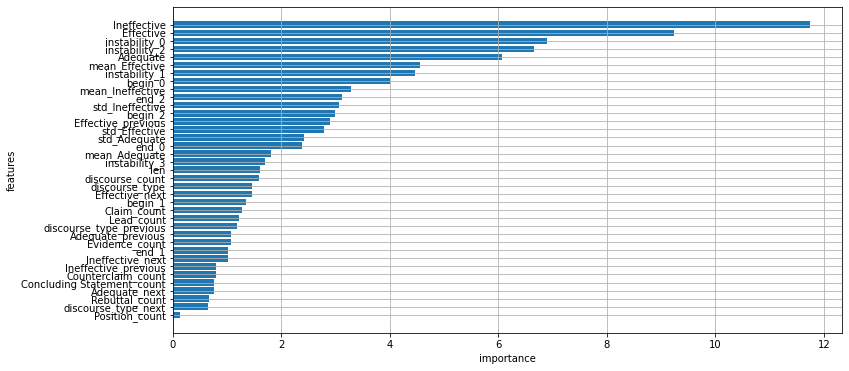

fold1 : CV=0.5902


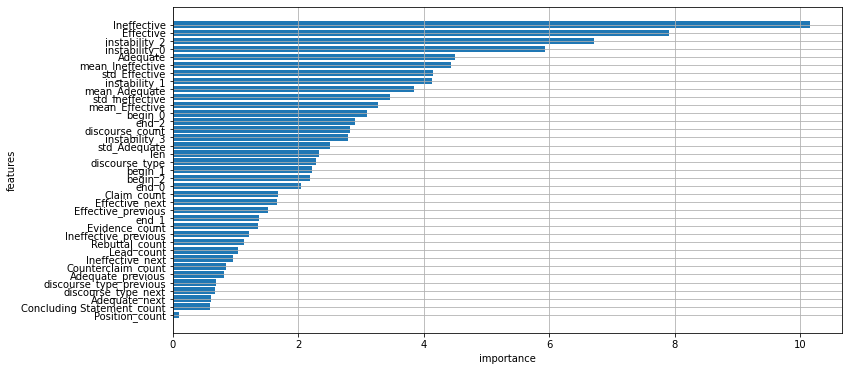

fold2 : CV=0.5776


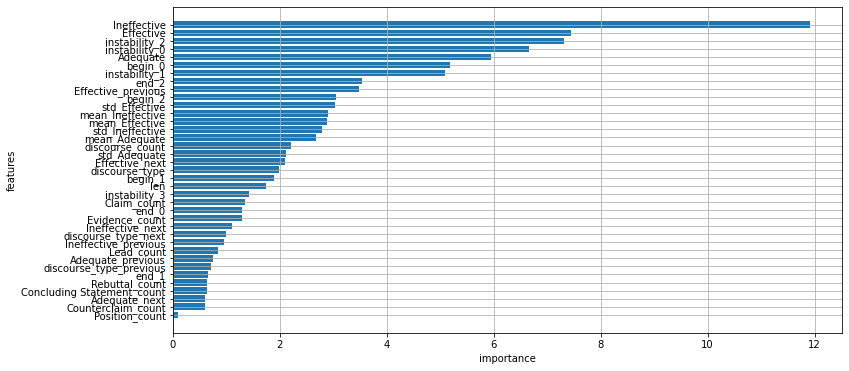

fold3 : CV=0.5903


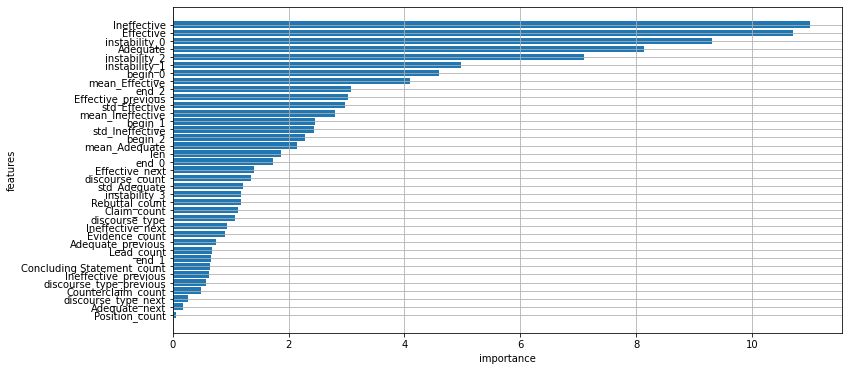

fold4 : CV=0.5838


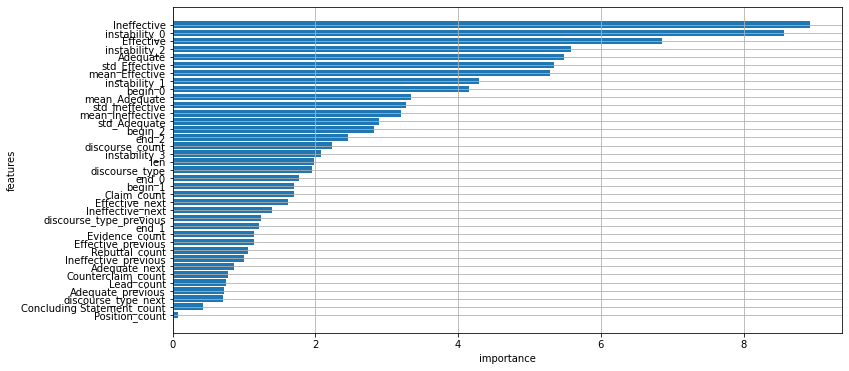

CV=0.5839


In [11]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cat_features = [0,1,2]

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[cols].values, label=trn_df['label'].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[cols].values, label=val_df['label'].values, cat_features=cat_features)

    model = catboost.CatBoostClassifier(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [12]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 47)


discourse_id      essay_id  \
0  0013cc385424  007ACE74B050   
1  9704a709b505  007ACE74B050   
2  c22adee811b6  007ACE74B050   
3  a10d361e54e4  007ACE74B050   
4  db3e453ec4e2  007ACE74B050   

                                      discourse_text discourse_type  \
0  Hi, i'm Isaac, i'm going to be writing about h...           Lead   
1  On my perspective, I think that the face is a ...       Position   
2  I think that the face is a natural landform be...          Claim   
3  If life was on Mars, we would know by now. The...       Evidence   
4  People thought that the face was formed by ali...   Counterclaim   

  discourse_effectiveness  Ineffective  Adequate  Effective  label      loss  \
0                Adequate     0.021704  0.927354   0.050943      1  0.075420   
1                Adequate     0.077561  0.879470   0.042969      1  0.128435   
2                Adequate     0.203750  0.780750   0.015500      1  0.247500   
3                Adequate     0.274948  0.712694   0.012357      1  0.338702   
4                Adequate     0.295401  0.697455   0.007143      1  0.360317   

   ... Claim_count  Evidence_count  Concluding Statement_count  Lead_count  \
0  ...           1               2                           1           1   
1  ...           1               2                           1           1   
2  ...           1               2                           1           1   
3  ...           1               2                           1           1   
4  ...           1               2                           1           1   

   Position_count  Counterclaim_count  Rebuttal_count  oof_ineffective  \
0               1                   2               1         0.035918   
1               1                   2               1         0.084695   
2               1                   2               1         0.210883   
3               1                   2               1         0.297277   
4               1                   2               1         0.271972   

   oof_adequate  oof_effective  
0      0.895379       0.068704  
1      0.849328       0.065977  
2      0.759909       0.029208  
3      0.686563       0.016160  
4      0.712467       0.015561  

[5 rows x 47 columns]

In [13]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5840


# Check for Fold0

In [14]:
import pandas as pd

fold = 0
val_ids = val_ids_list[fold]

local_pred_df = oof_df[oof_df['essay_id'].isin(val_ids)].reset_index(drop=True).copy()

kaggle_pred_df = pd.read_csv('kaggle_try3/stack_df.csv')
kaggle_pred_df = kaggle_pred_df[kaggle_pred_df['discourse_id'].isin(local_pred_df['discourse_id'])].reset_index(drop=True)
#kaggle_pred_df = local_pred_df[['discourse_id']].merge(kaggle_pred_df, on='discourse_id', how='left').reset_index(drop=True)

kaggle_sub_df = pd.read_csv('kaggle_try3/submission.csv')
kaggle_sub_df = kaggle_sub_df[kaggle_sub_df['discourse_id'].isin(local_pred_df['discourse_id'])].reset_index(drop=True)
#kaggle_sub_df = local_pred_df[['discourse_id']].merge(kaggle_sub_df, on='discourse_id', how='left').reset_index(drop=True)

local_pred_df = kaggle_sub_df[['discourse_id']].merge(local_pred_df, on='discourse_id', how='left').reset_index(drop=True)

In [15]:
local_pred_df.shape, kaggle_pred_df.shape, kaggle_sub_df.shape

((7303, 47), (7303, 5), (7303, 4))

In [16]:
local_pred_df[['discourse_id','oof_ineffective','oof_adequate','oof_effective','Ineffective','Adequate','Effective','prob_seq']].head(5)

discourse_id  oof_ineffective  oof_adequate  oof_effective  Ineffective  \
0  0013cc385424         0.035918      0.895379       0.068704     0.021704   
1  9704a709b505         0.084695      0.849328       0.065977     0.077561   
2  c22adee811b6         0.210883      0.759909       0.029208     0.203750   
3  a10d361e54e4         0.297277      0.686563       0.016160     0.274948   
4  db3e453ec4e2         0.271972      0.712467       0.015561     0.295401   

   Adequate  Effective                                           prob_seq  
0  0.927354   0.050943  [0.13634923, 0.8468392, 0.01681152, 0.07866441...  
1  0.879470   0.042969  [0.0755257, 0.86845165, 0.05602267, 0.06394375...  
2  0.780750   0.015500  [0.13821203, 0.8419575, 0.01983041, 0.15052359...  
3  0.712694   0.012357  [0.23645823, 0.7562572, 0.00728461, 0.3856053,...  
4  0.697455   0.007143  [0.24329548, 0.74282235, 0.01388219, 0.1884030...

In [17]:
kaggle_pred_df.head(5)

discourse_id  Ineffective  Adequate  Effective  \
0  0013cc385424     0.021700  0.927363   0.050937   
1  9704a709b505     0.077544  0.879495   0.042961   
2  c22adee811b6     0.203645  0.780854   0.015501   
3  a10d361e54e4     0.274836  0.712806   0.012358   
4  db3e453ec4e2     0.295359  0.697500   0.007141   

                                            prob_seq  
0  [[0.1363547  0.8468382  0.01680712]\n [0.07864...  
1  [[0.07551087 0.8684687  0.05602038]\n [0.06393...  
2  [[0.13819964 0.84196836 0.01983205]\n [0.15048...  
3  [[0.23641744 0.75629693 0.0072856 ]\n [0.38543...  
4  [[0.2432435  0.7428754  0.01388111]\n [0.18832...

In [18]:
kaggle_sub_df.head() #[['discourse_id','Ineffective','Adequate','Effective']].head(5)

discourse_id  Ineffective  Adequate  Effective
0  0013cc385424     0.035469  0.894734   0.069797
1  9704a709b505     0.084445  0.850620   0.064934
2  c22adee811b6     0.210883  0.759909   0.029208
3  a10d361e54e4     0.297277  0.686563   0.016160
4  db3e453ec4e2     0.271972  0.712467   0.015561

In [19]:
from sklearn.metrics import log_loss

local_score = log_loss(local_pred_df['label'].values, local_pred_df[['oof_ineffective','oof_adequate','oof_effective']].values)
print('local_score = {:.4f}'.format(local_score))

kaggle_score = log_loss(local_pred_df['label'].values, kaggle_sub_df[['Ineffective','Adequate','Effective']].values)
print('kaggle_score = {:.4f}'.format(kaggle_score))

local_score = 0.5778
kaggle_score = 0.5777


In [20]:
# without stacking

local_score = log_loss(local_pred_df['label'].values, local_pred_df[['Ineffective','Adequate','Effective']].values)
print('local_score = {:.7f}'.format(local_score))

kaggle_score = log_loss(local_pred_df['label'].values, kaggle_pred_df[['Ineffective','Adequate','Effective']].values)
print('kaggle_score = {:.7f}'.format(kaggle_score))

local_score = 0.5817417
kaggle_score = 0.5817464
